In [155]:
from keras.preprocessing import image
from keras.applications.resnet import preprocess_input, ResNet50
import numpy as np
from keras import metrics
from keras.models import Model, model_from_json
from keras.layers import Dense, GlobalAveragePooling2D, Input, Rescaling, Dropout, BatchNormalization
from keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import os
import random
import shutil
import tensorflow as tf


In [ ]:
img_width, img_height = 224, 224
epochs = 5
batch_size = 32

In [ ]:
inputs = Input(shape=(img_width, img_height, 3))
x = Rescaling(1./255)(inputs) 
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=x)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x=BatchNormalization()(x)
x=Dropout(0.4)(x)
predictions = Dense(2, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy',
metrics.AUC(name='auc')])

In [158]:

source_dir = 'lfw-deepfunneled'
target_dir = 'data/0'
shutil.rmtree(target_dir)
os.makedirs(target_dir, exist_ok=True)
image_paths = []
for root, _, files in os.walk(source_dir):
    for f in files:
        if f.lower().endswith((".jpg", ".jpeg", ".png")):
            image_paths.append(os.path.join(root, f))
n_samples = min(1400, len(image_paths))
selected_images = random.sample(image_paths, n_samples)
for i, img_path in enumerate(selected_images):
    filename = f"img_{i:03d}" + os.path.splitext(img_path)[1]
    shutil.copy(img_path, os.path.join(target_dir, filename))


In [159]:
train_dataset = image_dataset_from_directory(
    'data',
    image_size=(img_width, img_height),
    batch_size=batch_size,
    validation_split=0.125,
    subset='training',
    seed=42,
    label_mode="categorical"
)


validation_dataset = image_dataset_from_directory(
    'data',
    image_size=(img_width, img_height),
    batch_size=batch_size,
    validation_split=0.125,
    subset='validation',
    seed=42,
    label_mode="categorical"
)

Found 2581 files belonging to 2 classes.
Using 2259 files for training.
Found 2581 files belonging to 2 classes.
Using 322 files for validation.


In [160]:

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),       
    tf.keras.layers.RandomRotation(0.2),            
    tf.keras.layers.RandomZoom(0.2),                
    tf.keras.layers.RandomTranslation(0.1, 0.1),    
    tf.keras.layers.RandomContrast(0.2),            
])


In [161]:
augmented_train = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

In [162]:
augmented_train = augmented_train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


In [163]:
model.fit(
    augmented_train,
    epochs=epochs,
    validation_data=validation_dataset,
    verbose=1,
)

Epoch 1/5
142/142 ━━━━━━━━━━━━━━━━━━━━ 111s 663ms/step - accuracy: 0.8455 - auc: 0.8993 - loss: 0.3583 - val_accuracy: 0.6211 - val_auc: 0.7995 - val_loss: 0.5559
Epoch 2/5
142/142 ━━━━━━━━━━━━━━━━━━━━ 90s 634ms/step - accuracy: 0.9115 - auc: 0.9582 - loss: 0.2343 - val_accuracy: 0.4969 - val_auc: 0.7380 - val_loss: 1.1782
Epoch 3/5
142/142 ━━━━━━━━━━━━━━━━━━━━ 87s 614ms/step - accuracy: 0.9185 - auc: 0.9681 - loss: 0.2111 - val_accuracy: 0.4969 - val_auc: 0.7386 - val_loss: 1.7031
Epoch 4/5
142/142 ━━━━━━━━━━━━━━━━━━━━ 87s 616ms/step - accuracy: 0.9225 - auc: 0.9743 - loss: 0.1937 - val_accuracy: 0.5124 - val_auc: 0.6892 - val_loss: 4.2586
Epoch 5/5
142/142 ━━━━━━━━━━━━━━━━━━━━ 93s 655ms/step - accuracy: 0.9314 - auc: 0.9794 - loss: 0.1742 - val_accuracy: 0.9596 - val_auc: 0.9934 - val_loss: 0.1046


In [170]:
results=model.evaluate(validation_dataset)


21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 545ms/step - accuracy: 0.9596 - auc: 0.9934 - loss: 0.1046


In [165]:
classes = ['0', '1']

In [166]:
model_json = model.to_json()
json_file = open("resnet50_face.json", "w")
json_file.write(model_json)
json_file.close()
model.save_weights("resnet50_face.weights.h5")


In [167]:
json_file = open("resnet50_face.json", "r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("resnet50_face.weights.h5")
loaded_model.compile(loss="categorical_crossentropy", optimizer="SGD", metrics=["accuracy"])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[[0.9997507  0.00511979]]
0


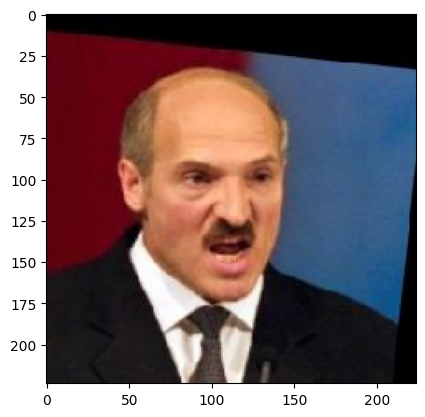

In [168]:
img = image.load_img('lfw-deepfunneled/Alexander_Lukashenko/Alexander_Lukashenko_0001.jpg', 
target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
plt.imshow(img)
prediction = loaded_model.predict(x)
print(prediction)
print(classes[np.argmax(prediction)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
[[0.54497385 0.9150179 ]]
1


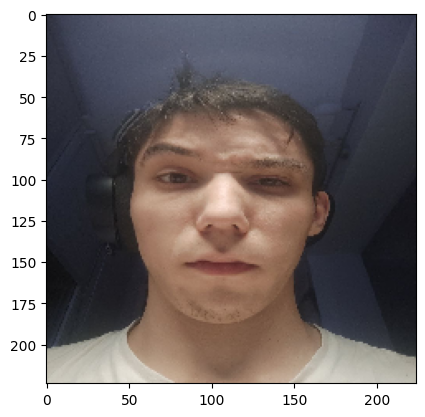

In [169]:
img = image.load_img('tester.jpg', target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
prediction = loaded_model.predict(x)
plt.imshow(img)
print(prediction)
print(classes[np.argmax(prediction)])